## Preliminaries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_friedman1, make_friedman2, make_friedman3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from online_cp.CPS import NearestNeighboursPredictionMachine, KernelRidgePredictionMachine
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from joblib import Parallel, delayed
import sys

In [2]:
def generate_data(n_samples=10000, n_features=20, relationship='make_regression', noise=0.1, random_state=None):
    if relationship == 'make_regression':
        X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=noise, random_state=random_state)
        
    elif relationship == 'friedman1':
        X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=noise, random_state=random_state)
        
    elif relationship == 'friedman2':
        X, y = make_friedman2(n_samples=n_samples, noise=noise, random_state=random_state)
        
    elif relationship == 'friedman3':
        X, y = make_friedman3(n_samples=n_samples, noise=noise, random_state=random_state)
        
    else:
        raise ValueError(f"Unsupported relationship: {relationship}")

    # Min-max scale the target
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

    # Convert to DataFrame
    df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])
    df['Target'] = y_scaled
    
    return df
    
    
def model_selection(X_train, y_train, estimator, param_grid, n_splits=5, random_state=None, n_jobs=-1, scoring="neg_mean_squared_error"):
    if "n_neighbors" in param_grid:
        param_grid["n_neighbors"] = [k for k in param_grid["n_neighbors"] if k <= len(X_train)*(1 - 1/n_splits)]
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=n_jobs, cv=cv, verbose=0, scoring=scoring)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score

def create_utility_func(threshold, tp, tn, fp, fn):
    def utility_func(y_value, decision, threshold=threshold, tp=tp, tn=tn, fp=fp, fn=fn):
        y_value = int(y_value >= threshold)
        return (
            tp if decision and y_value else
            fp if decision else
            fn if y_value else
            tn
        )
                    
    return utility_func

def compute_expected_utility(cdf_vals, utility_func, decision):
    # Compute the utilities
    utilities = np.array([utility_func(y, decision) for y in cdf_vals])

    # Compute CDF jumps
    cdf_len = len(cdf_vals)
    delta_Q_star = np.diff(np.array([i / cdf_len for i in range(cdf_len)]))

    # Compute expected utility
    expected_utility = np.sum(utilities[:-1] * delta_Q_star)

    return expected_utility


def optimal_decision_making(Decisions, y_test, utility_func):
    optimal_decisions, utilities = zip(
        *[
            max(((d, utility_func(y, d)) for d in Decisions), key=lambda x: x[1])
            for y in y_test
        ]
    )
    
    return optimal_decisions, utilities


def make_decisions(expected_utilities, utility_func, y_test):
    decisions_made = []
    utilities = []
    for i, expected_utility in enumerate(zip(*expected_utilities)):
        max_utility = max(expected_utility)
        decision = expected_utility.index(max_utility)
        decisions_made.append(decision)
        utilities.append(utility_func(y_test[i], decision))
        
    return decisions_made, utilities


def online_cpdm_model_selection_knn(X_train, y_train, search_space, n_splits=5, random_state=None):
    def eval_sample(cps_model, x, y, epsilon=0.05):
        tau = np.random.uniform(0, 1)
        cpd = cps_model.predict_cpd(x=x)
        Gamma = cpd.predict_set(tau=tau, epsilon=epsilon)
        return cpd.err(Gamma=Gamma, y=y)


    def eval_k(k, kf, X, y):
        cv_errors = []
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            cps = NearestNeighboursPredictionMachine(k=k)
            cps.learn_initial_training_set(X_train, y_train)

            val_errors = Parallel(n_jobs=-1)(
                delayed(eval_sample)(cps, x, y)
                for x, y in zip(X_val, y_val)
            )

            cv_errors.append(np.mean(val_errors))

        return k, np.mean(cv_errors)

    # Setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    valid_ks = [k for k in search_space["n_neighbors"] if k <= len(X_train)*(1 - 1/n_splits)]

    results = Parallel(n_jobs=-1)(
        delayed(eval_k)(k, kf, X_train, y_train) for k in valid_ks
    )
    
    best_k, _ = min(results, key=lambda x: x[1])
    
    return best_k
    
def online_cpdm_model_selection_krr(X_train, y_train, search_space, n_splits=5, random_state=None):
    def eval_sample(cps_model, x, y, epsilon=0.05):
        tau = np.random.uniform(0, 1)
        cpd = cps_model.predict_cpd(x=x)
        Gamma = cpd.predict_set(tau=tau, epsilon=epsilon)
        return cpd.err(Gamma=Gamma, y=y)

    def eval_params(params, kf, X, y):
        cv_errors = []
        kernel = C(params['kernel__k1__constant_value']) * RBF(length_scale=params['kernel__k2__length_scale'])

        for train_idx, val_idx in kf.split(X):
            X_tr, y_tr = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            cps = KernelRidgePredictionMachine(kernel=kernel, a=params['alpha'])
            cps.learn_initial_training_set(X_tr, y_tr)

            val_errors = Parallel(n_jobs=-1)(
                delayed(eval_sample)(cps, x, y)
                for x, y in zip(X_val, y_val)
            )

            cv_errors.append(np.mean(val_errors))

        return params, np.mean(cv_errors)

    # Setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    from itertools import product
    all_param_combinations = list(product(
        search_space["alpha"],
        search_space["kernel__k1__constant_value"],
        search_space["kernel__k2__length_scale"]
    ))

    param_dicts = [
        {
            "alpha": alpha,
            "kernel__k1__constant_value": const_val,
            "kernel__k2__length_scale": length_scale
        }
        for alpha, const_val, length_scale in all_param_combinations
    ]

    results = Parallel(n_jobs=-1)(
        delayed(eval_params)(params, kf, X_train, y_train)
        for params in param_dicts
    )

    best_params, _ = min(results, key=lambda x: x[1])

    return best_params

In [43]:
import numpy as np
from crepes import WrapRegressor
from copy import deepcopy
from online_cp.CPS import RidgePredictionMachine
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


def inductive(model, Decisions, utility_func, X_train, y_train, X_cal, y_cal, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Wrap the model with conformal prediction
    cps = WrapRegressor(model)
    cps.calibrate(X_cal, y_cal, cps=True)

    # Get CPDs for the test samples
    cpds = cps.predict_cps(X_test, return_cpds=True)
    
    expected_utilities = []
    for d in Decisions:
        # Compute the expected utility
        expected_utilities_d = []
        for i in range(len(X_test)):
            expected_utility = compute_expected_utility(cpds[i], utility_func, d)
            expected_utilities_d.append(expected_utility)

        expected_utilities.append(expected_utilities_d)
                    
    decisions, utilities = make_decisions(expected_utilities, utility_func, y_test)

    return cpds, decisions, utilities

def online_v2(cps, Decisions, utility_func, X_train, y_train, X_test, y_test, search_space, n_splits=5, random_state=None):
    X_seen = X_train
    y_seen = y_train
    
    if isinstance(cps, NearestNeighboursPredictionMachine):
        # Hyperparameter tuning for k
        best_k = online_cpdm_model_selection_knn(
            X_seen,
            y_seen,
            search_space=search_space,
            n_splits=n_splits,
            random_state=random_state
        )
        chosen_cps = NearestNeighboursPredictionMachine(k=best_k)
    elif isinstance(cps, KernelRidgePredictionMachine):
        # Hyperparameter tuning
        best_params = online_cpdm_model_selection_krr(
            X_seen,
            y_seen,
            search_space=search_space,
            n_splits=n_splits,
            random_state=random_state
        )
        kernel = C(best_params['kernel__k1__constant_value']) * RBF(length_scale=best_params['kernel__k2__length_scale'])
        chosen_cps = KernelRidgePredictionMachine(kernel=kernel, a=best_params['alpha'])
    else:
        chosen_cps = deepcopy(cps)
        
    chosen_cps.learn_initial_training_set(X_seen, y_seen)
    
    cpds = []
    expected_utilities = [[] for _ in Decisions]
    for i, (x, y) in enumerate(zip(X_test, y_test)):
        # Produce conformal predictive distribution
        cpd, precomputed = chosen_cps.predict_cpd(x=x, return_update=True)
        cpds.append(cpd)

        for i, d in enumerate(Decisions):
            # Compute the expected utility from the cpd
            expected_utility = compute_expected_utility(cpd.y_vals, utility_func, d)
            expected_utilities[i].append(expected_utility)
        
        X_seen = np.append(X_seen, [x], axis=0)
        y_seen = np.append(y_seen, [y])
        
        # Learn new object
        if isinstance(chosen_cps, KernelRidgePredictionMachine):                
            best_params = online_cpdm_model_selection_krr(
                X_seen,
                y_seen,
                search_space=search_space,
                n_splits=n_splits,
                random_state=random_state
            )
            kernel = C(best_params['kernel__k1__constant_value']) * RBF(length_scale=best_params['kernel__k2__length_scale'])
            chosen_cps = KernelRidgePredictionMachine(kernel=kernel, a=best_params['alpha'])
            chosen_cps.learn_initial_training_set(X_seen, y_seen)
        else:
            chosen_cps.learn_one(x=x, y=y, precomputed=precomputed)
        
        if isinstance(chosen_cps, NearestNeighboursPredictionMachine):
            best_k = online_cpdm_model_selection_knn(
                X_seen,
                y_seen,
                search_space=search_space,
                n_splits=n_splits,
                random_state=random_state,
            )
            
            chosen_cps.k = best_k 
    
    decisions, utilities = make_decisions(expected_utilities, utility_func, y_test)
    
    if isinstance(cps, NearestNeighboursPredictionMachine):
        print(best_k)
    if isinstance(cps, KernelRidgePredictionMachine):
        print(best_params)
    if isinstance(cps, RidgePredictionMachine):
        print(chosen_cps.a)
    

    return cpds, decisions, utilities

# Linear

### Data generation

In [4]:
from sklearn.model_selection import train_test_split

synthetic_data = generate_data(
    n_samples=2500,
    n_features=5,
    relationship='make_regression',
    noise=0.1,
    random_state=2025
)

X = synthetic_data.drop(columns=["Target"])
y = synthetic_data["Target"]

# Split data
X_proper, X_test, y_proper, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_proper, y_proper, test_size=0.2)

def to_numpy_safe(x):
    return x.to_numpy() if hasattr(x, "to_numpy") else x

# Convert to numpy arrays if needed
X_proper = to_numpy_safe(X_proper)
y_proper = to_numpy_safe(y_proper)
X_train  = to_numpy_safe(X_train)
y_train  = to_numpy_safe(y_train)
X_cal    = to_numpy_safe(X_cal)
y_cal    = to_numpy_safe(y_cal)
X_test   = to_numpy_safe(X_test)
y_test   = to_numpy_safe(y_test)

### Running code

In [5]:
from sklearn.linear_model import Ridge

Decisions={0,1}
utility_func = create_utility_func(threshold=0.5, tp=1, tn=1, fp=-5, fn=-5)

search_space_ridge = {
    'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
}

random_state = 2025
n_splits = 5

best_params_ridge, _ = model_selection(
    X_train,
    y_train,
    estimator=Ridge(random_state=random_state),
    param_grid=search_space_ridge,
    n_splits=n_splits,
    random_state=random_state,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
model = Ridge(random_state=random_state, **best_params_ridge)

print(best_params_ridge)

cpds_inductive, decisions_inductive, utilities_inductive = inductive(
    model=model,
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_train,
    y_train=y_train,
    X_cal=X_cal,
    y_cal=y_cal,
    X_test=X_test,
    y_test=y_test
)


cpds_online, decisions_online, utilities_online = online_v2(
    cps=RidgePredictionMachine(a=0.001),
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_proper,
    y_train=y_proper,
    X_test=X_test,
    y_test=y_test,
    search_space = search_space_ridge
)

optimal_decisions, optimal_utilities = optimal_decision_making(Decisions, y_test, utility_func)

{'alpha': 0.001}


### Creating the plots on when online CPDM is wrong

In [6]:
import matplotlib.pyplot as plt


def plot_wrong_examples(optimal_decisions, cpds_online, decisions_online, cpds_inductive, decisions_inductive):
    incorrect_mask_online = [decision != optimal_decision for decision, optimal_decision in zip(decisions_online, optimal_decisions)]
    incorrect_cpds_online = [cpd for cpd, mask in zip(cpds_online, incorrect_mask_online) if mask]
    incorrect_cpds_inductive = [cpd for cpd, mask in zip(cpds_inductive, incorrect_mask_online) if mask]

    y_vals = [y_val for y_val, mask in zip(y_test, incorrect_mask_online) if mask]


    for i, (cpd_online, cpd_inductive) in enumerate(zip(incorrect_cpds_online, incorrect_cpds_inductive)):
        y_val = y_vals[i]

        sorted_vals_online = np.sort(cpd_online.y_vals)
        sorted_vals_inductive = np.sort(cpd_inductive)
        cdf_online = np.arange(1, len(sorted_vals_online) + 1) / len(sorted_vals_online)
        cdf_inductive = np.array([i/len(cpd_inductive) for i in range(len(cpd_inductive))])

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        # Online subplot
        axes[0].plot(sorted_vals_online, cdf_online, marker='.', linestyle='-', label='Online')
        axes[0].axvline(x=y_val, color='red', linestyle='--', label='Actual y')
        axes[0].set_title(f"Online CPD #{i+1}")
        axes[0].set_xlabel("Value")
        axes[0].set_ylabel("Cumulative Probability")
        axes[0].grid(True)
        axes[0].legend()

        # Inductive subplot
        axes[1].plot(sorted_vals_inductive, cdf_inductive, marker='.', linestyle='-', label='Inductive', color='orange')
        axes[1].axvline(x=y_val, color='red', linestyle='--', label='Actual y')
        axes[1].set_title(f"Inductive CPD #{i+1}")
        axes[1].set_xlabel("Value")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()


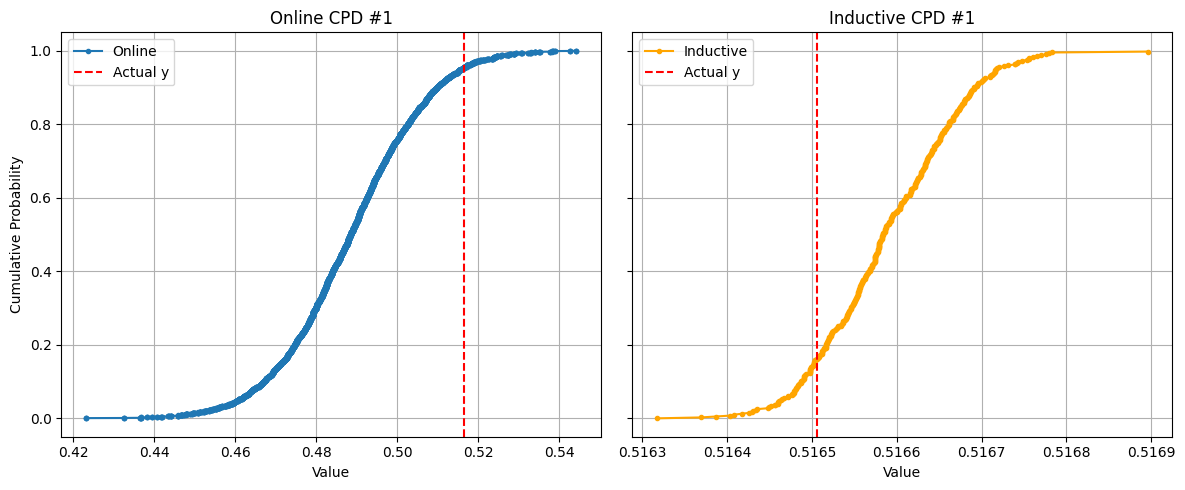

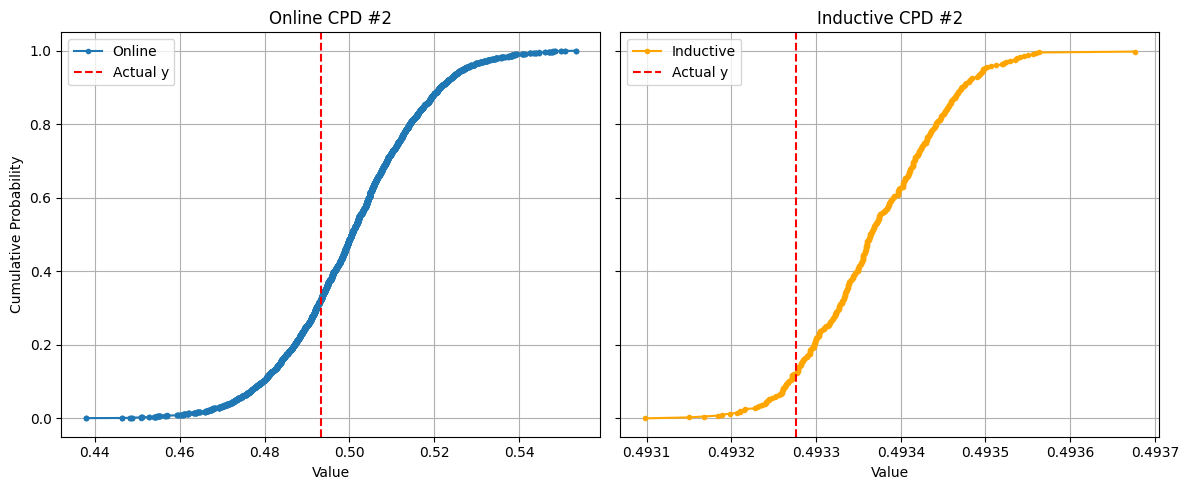

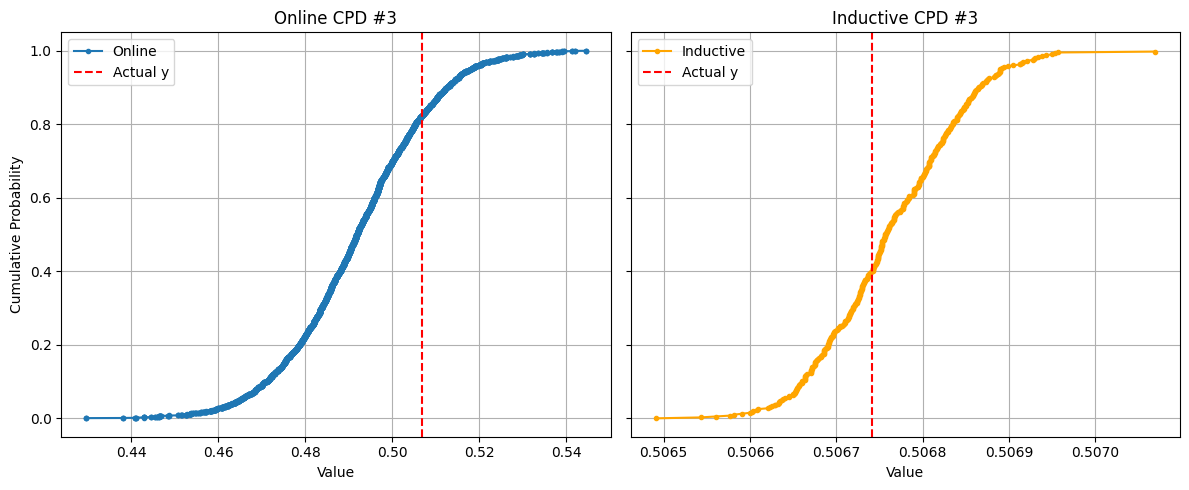

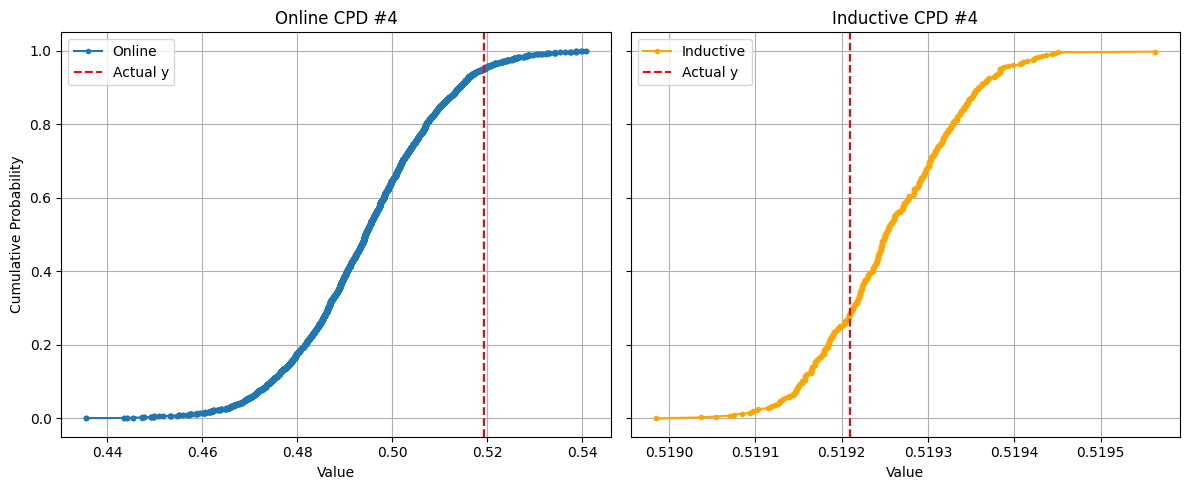

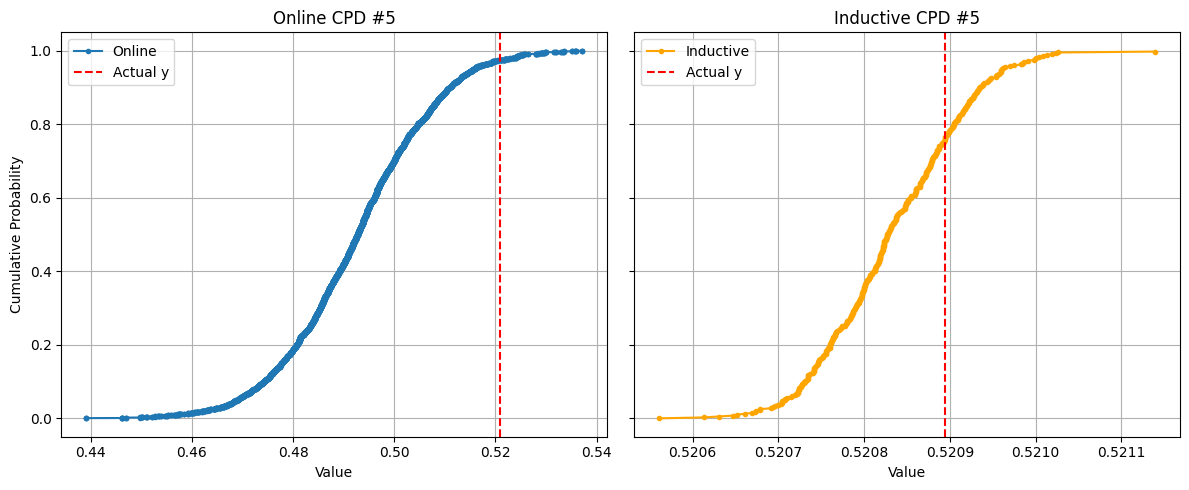

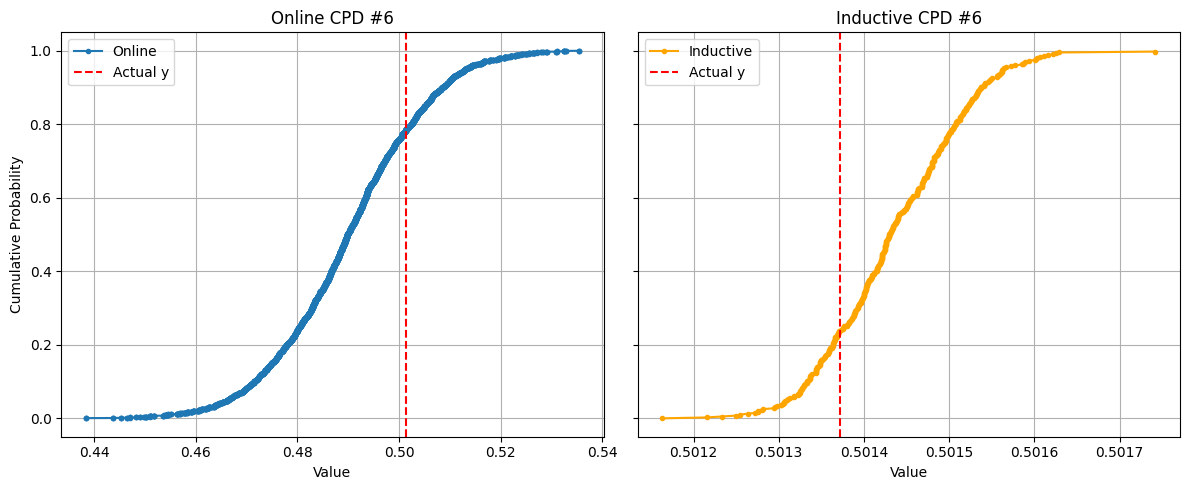

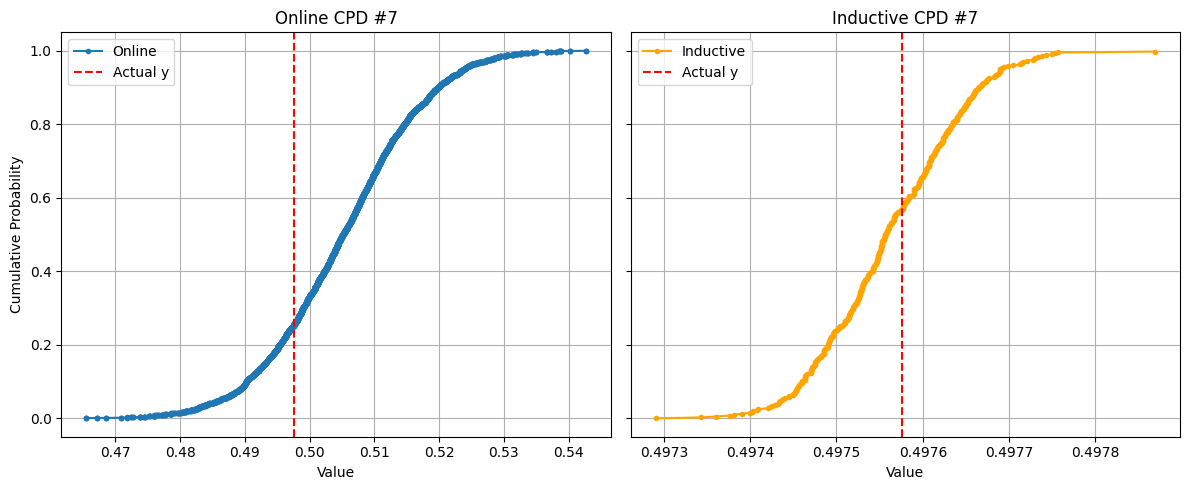

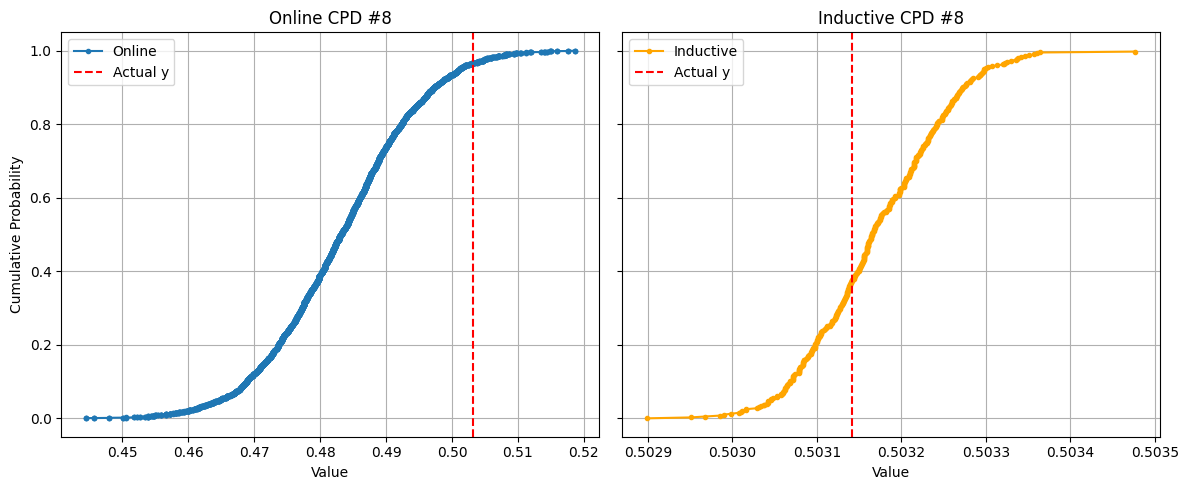

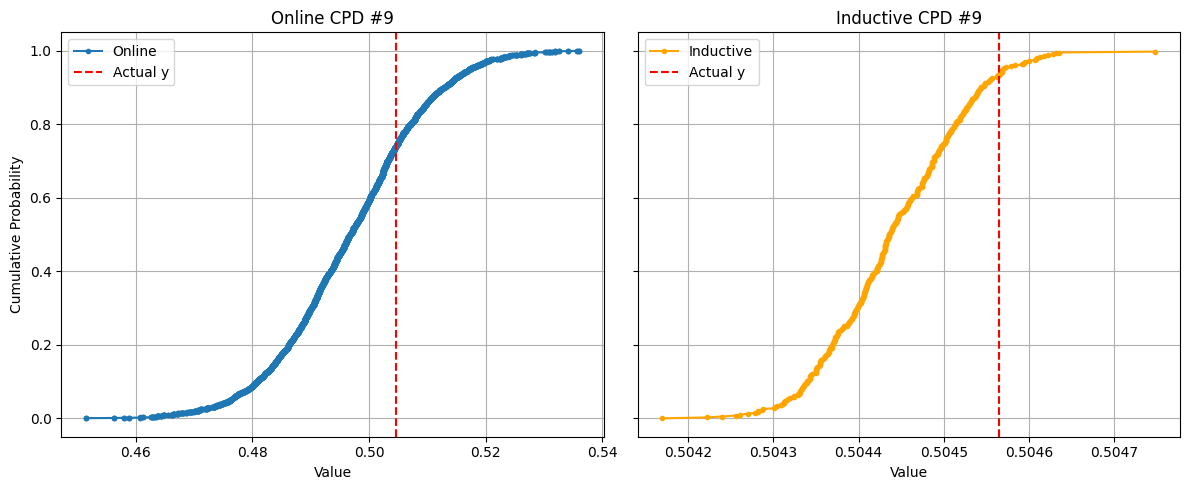

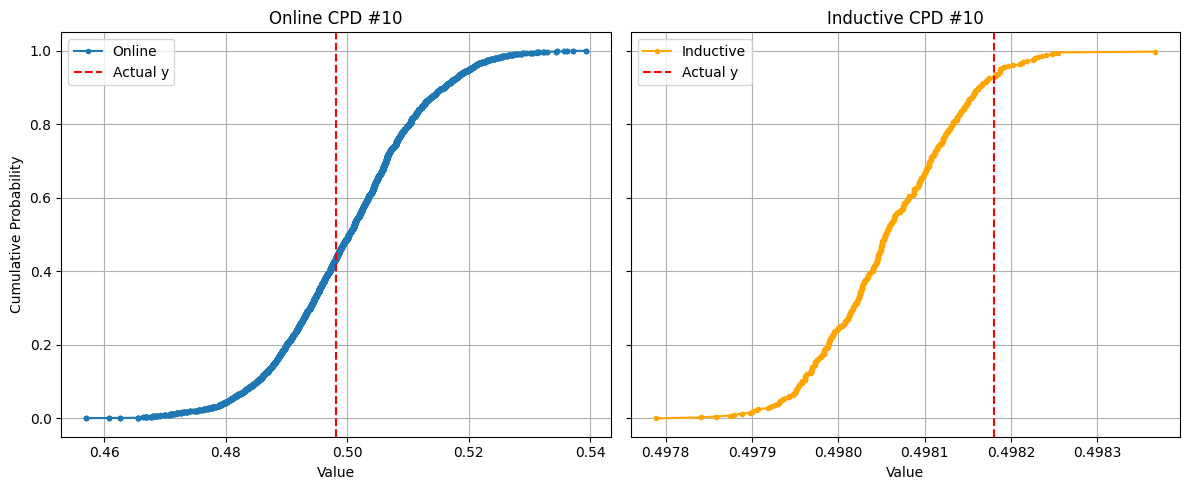

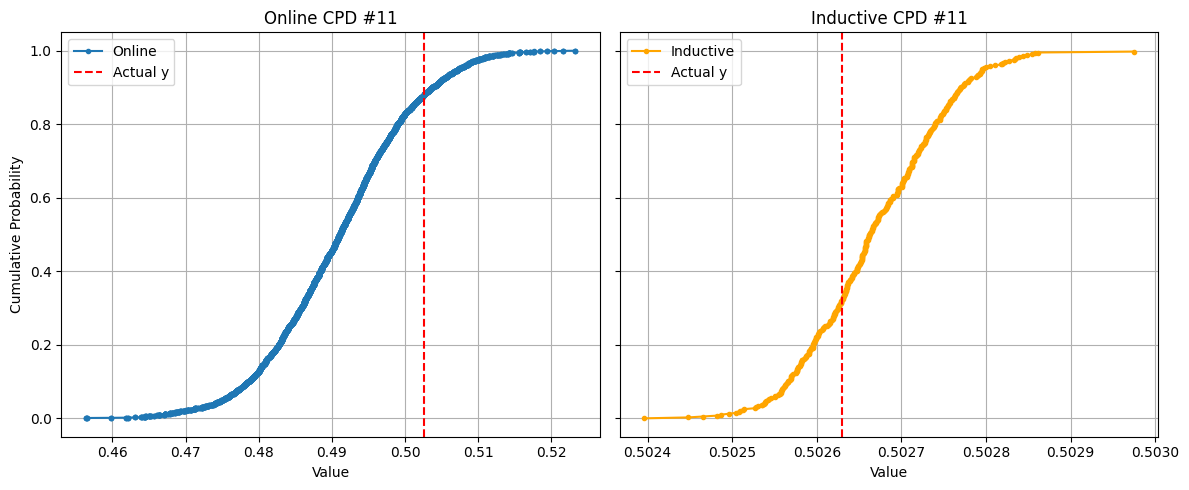

In [7]:
plot_wrong_examples(optimal_decisions, cpds_online, decisions_online, cpds_inductive, decisions_inductive)

In [8]:
incorrect_mask_inductive = [decision != optimal_decision for decision, optimal_decision in zip(decisions_inductive, optimal_decisions)]
incorrect_mask_online = [decision != optimal_decision for decision, optimal_decision in zip(decisions_online, optimal_decisions)]

print(f"# of mistakes inductive: {sum(incorrect_mask_inductive)}")
print(f"# of mistakes online: {sum(incorrect_mask_online)}")

# of mistakes inductive: 0
# of mistakes online: 11


# KNN

In [9]:
from sklearn.model_selection import train_test_split

synthetic_data = generate_data(
    n_samples=200,
    n_features=5,
    relationship='friedman1',
    noise=0.1,
    random_state=2025
)

X = synthetic_data.drop(columns=["Target"])
y = synthetic_data["Target"]

# Split data
X_proper, X_test, y_proper, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_proper, y_proper, test_size=0.2)

def to_numpy_safe(x):
    return x.to_numpy() if hasattr(x, "to_numpy") else x

# Convert to numpy arrays if needed
X_proper = to_numpy_safe(X_proper)
y_proper = to_numpy_safe(y_proper)
X_train  = to_numpy_safe(X_train)
y_train  = to_numpy_safe(y_train)
X_cal    = to_numpy_safe(X_cal)
y_cal    = to_numpy_safe(y_cal)
X_test   = to_numpy_safe(X_test)
y_test   = to_numpy_safe(y_test)

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from online_cp.CPS import NearestNeighboursPredictionMachine

Decisions={0,1}
utility_func = create_utility_func(threshold=0.5, tp=1, tn=1, fp=-5, fn=-5)

search_space_knn = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 20]
}

random_state = 2025
n_splits = 5

best_params_knn, _ = model_selection(
    X_train,
    y_train,
    estimator=KNeighborsRegressor(metric="euclidean", n_jobs=-1),
    param_grid=search_space_knn,
    n_splits=n_splits,
    random_state=random_state,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
model = KNeighborsRegressor(metric="euclidean", n_jobs=-1, **best_params_knn)

print(best_params_knn)

cpds_inductive, decisions_inductive, utilities_inductive = inductive(
    model=model,
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_train,
    y_train=y_train,
    X_cal=X_cal,
    y_cal=y_cal,
    X_test=X_test,
    y_test=y_test
)


cpds_online, decisions_online, utilities_online = online_v2(
    cps=NearestNeighboursPredictionMachine(k=5),
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_proper,
    y_train=y_proper,
    X_test=X_test,
    y_test=y_test,
    search_space=search_space_knn
)

optimal_decisions, optimal_utilities = optimal_decision_making(Decisions, y_test, utility_func)

{'n_neighbors': 7}
15


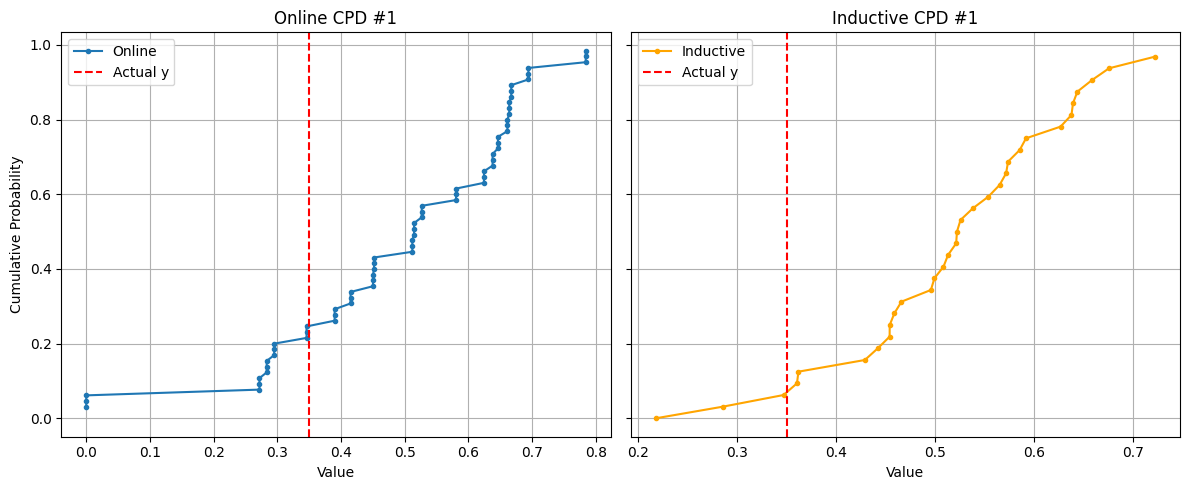

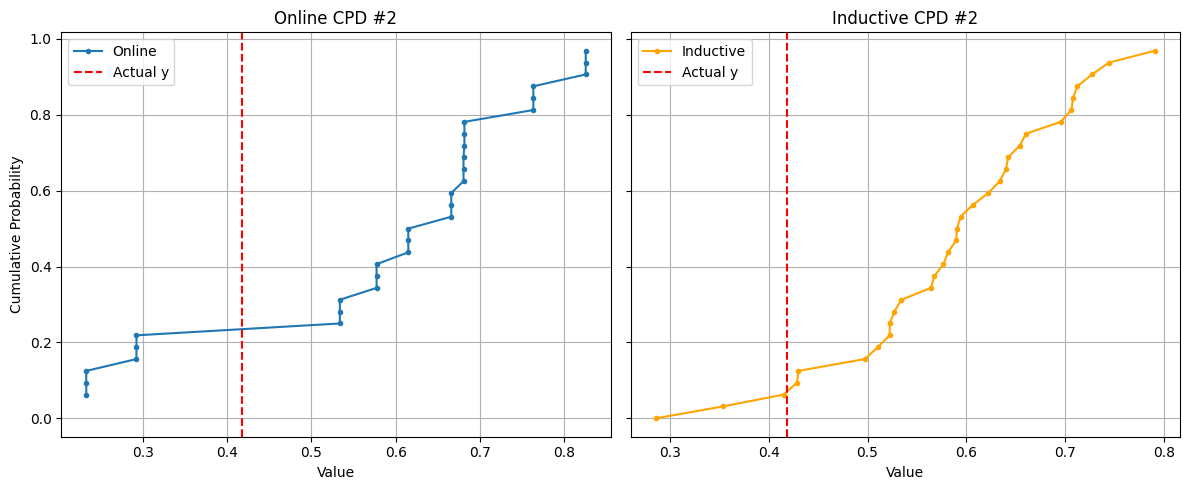

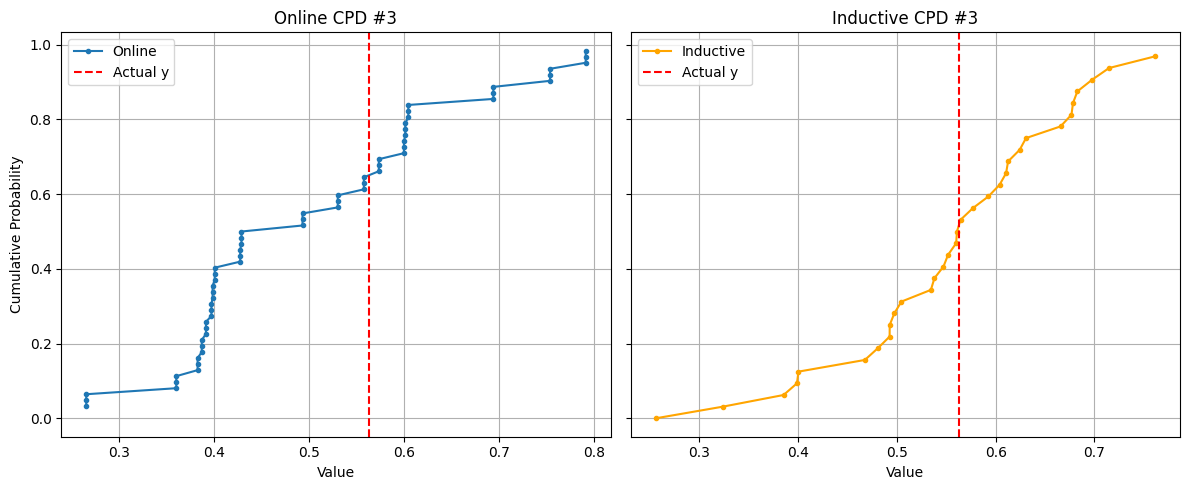

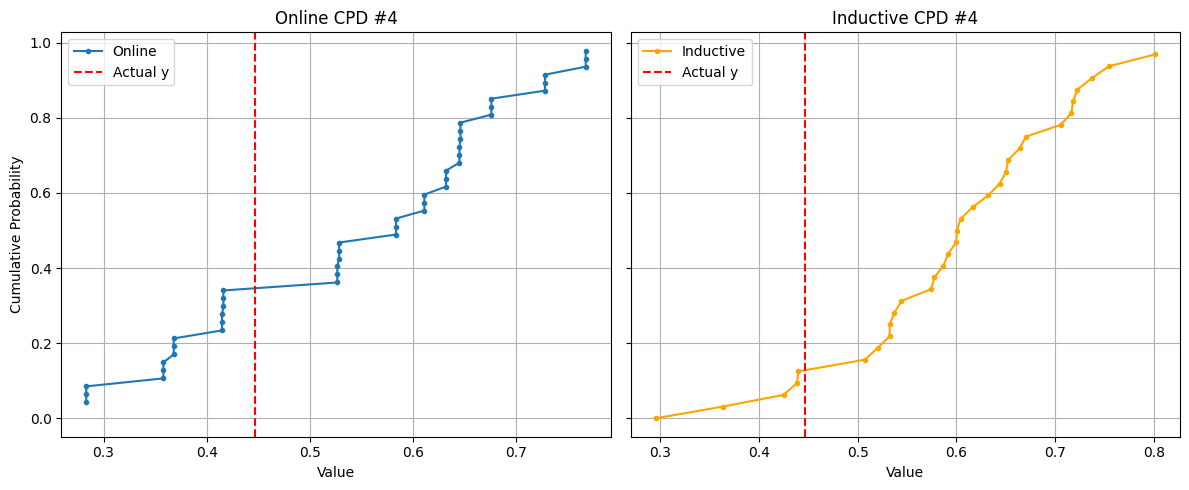

In [11]:
plot_wrong_examples(optimal_decisions, cpds_online, decisions_online, cpds_inductive, decisions_inductive)

In [12]:
incorrect_mask_inductive = [decision != optimal_decision for decision, optimal_decision in zip(decisions_inductive, optimal_decisions)]
incorrect_mask_online = [decision != optimal_decision for decision, optimal_decision in zip(decisions_online, optimal_decisions)]

print(f"# of mistakes inductive: {sum(incorrect_mask_inductive)}")
print(f"# of mistakes online: {sum(incorrect_mask_online)}")

# of mistakes inductive: 9
# of mistakes online: 4


# KRR

In [13]:
from sklearn.model_selection import train_test_split

synthetic_data = generate_data(
    n_samples=100,
    n_features=5,
    relationship='friedman1',
    noise=0.1,
    random_state=2025
)

X = synthetic_data.drop(columns=["Target"])
y = synthetic_data["Target"]

# Split data
X_proper, X_test, y_proper, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_proper, y_proper, test_size=0.2)

def to_numpy_safe(x):
    return x.to_numpy() if hasattr(x, "to_numpy") else x

# Convert to numpy arrays if needed
X_proper = to_numpy_safe(X_proper)
y_proper = to_numpy_safe(y_proper)
X_train  = to_numpy_safe(X_train)
y_train  = to_numpy_safe(y_train)
X_cal    = to_numpy_safe(X_cal)
y_cal    = to_numpy_safe(y_cal)
X_test   = to_numpy_safe(X_test)
y_test   = to_numpy_safe(y_test)

In [14]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from online_cp.CPS import KernelRidgePredictionMachine


Decisions={0,1}
utility_func = create_utility_func(threshold=0.5, tp=1, tn=1, fp=-5, fn=-5)

search_space_knn = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 20]
}

random_state = 2025
n_splits = 5

search_space_krr ={
    'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'kernel__k1__constant_value': [ 1e-2, 1e-1, 1e0, 1e1, 1e2],
    'kernel__k2__length_scale': [1e-2, 1e-1, 1e0, 1e1, 1e2]
}


best_params_krr, _ = model_selection(
    X_train,
    y_train,
    estimator=KernelRidge(kernel=C(1.0, constant_value_bounds=(1e-10, 1e10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-40, 1e10))),
    param_grid=search_space_krr,
    n_splits=n_splits,
    random_state=random_state,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
best_kernel = C(best_params_krr['kernel__k1__constant_value']) * RBF(best_params_krr['kernel__k2__length_scale'])
model = KernelRidge(kernel=best_kernel, alpha=best_params_krr['alpha'])


print(best_params_krr)

cpds_inductive, decisions_inductive, utilities_inductive = inductive(
    model=model,
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_train,
    y_train=y_train,
    X_cal=X_cal,
    y_cal=y_cal,
    X_test=X_test,
    y_test=y_test
)


kernel = C(1.0) * RBF(length_scale=1.0)
krpm = KernelRidgePredictionMachine(kernel=kernel)
cpds_online, decisions_online, utilities_online = online_v2(
    cps=krpm,
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_proper,
    y_train=y_proper,
    X_test=X_test,
    y_test=y_test,
    search_space=search_space_krr
)

optimal_decisions, optimal_utilities = optimal_decision_making(Decisions, y_test, utility_func)


{'alpha': 0.001, 'kernel__k1__constant_value': 100.0, 'kernel__k2__length_scale': 1.0}
{'alpha': 0.1, 'kernel__k1__constant_value': 10.0, 'kernel__k2__length_scale': 1.0}


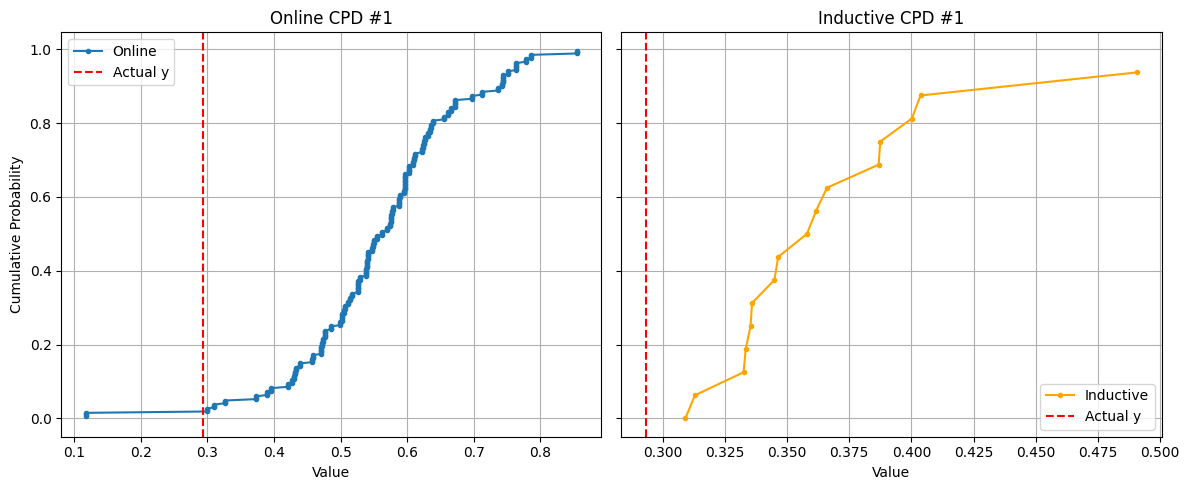

In [15]:
plot_wrong_examples(optimal_decisions, cpds_online, decisions_online, cpds_inductive, decisions_inductive)

In [16]:
incorrect_mask_inductive = [decision != optimal_decision for decision, optimal_decision in zip(decisions_inductive, optimal_decisions)]
incorrect_mask_online = [decision != optimal_decision for decision, optimal_decision in zip(decisions_online, optimal_decisions)]

print(f"# of mistakes inductive: {sum(incorrect_mask_inductive)}")
print(f"# of mistakes online: {sum(incorrect_mask_online)}")

# of mistakes inductive: 1
# of mistakes online: 1


# Testing Ridge with learn initial each time

In [27]:
def online_v3(cps, Decisions, utility_func, X_train, y_train, X_test, y_test, search_space, n_splits=5, random_state=None):
    X_seen = X_train
    y_seen = y_train
    
    if isinstance(cps, NearestNeighboursPredictionMachine):
        # Hyperparameter tuning for k
        best_k = online_cpdm_model_selection_knn(
            X_seen,
            y_seen,
            search_space=search_space,
            n_splits=n_splits,
            random_state=random_state
        )
        chosen_cps = NearestNeighboursPredictionMachine(k=best_k)
    elif isinstance(cps, KernelRidgePredictionMachine):
        # Hyperparameter tuning
        best_params = online_cpdm_model_selection_krr(
            X_seen,
            y_seen,
            search_space=search_space,
            n_splits=n_splits,
            random_state=random_state
        )
        kernel = C(best_params['kernel__k1__constant_value']) * RBF(length_scale=best_params['kernel__k2__length_scale'])
        chosen_cps = KernelRidgePredictionMachine(kernel=kernel, a=best_params['alpha'])
    else:
        chosen_cps = deepcopy(cps)
        
    chosen_cps.learn_initial_training_set(X_seen, y_seen)
    
    cpds = []
    expected_utilities = [[] for _ in Decisions]
    for i, (x, y) in enumerate(zip(X_test, y_test)):
        # Produce conformal predictive distribution
        cpd, precomputed = chosen_cps.predict_cpd(x=x, return_update=True)
        cpds.append(cpd)

        for i, d in enumerate(Decisions):
            # Compute the expected utility from the cpd
            expected_utility = compute_expected_utility(cpd.y_vals, utility_func, d)
            expected_utilities[i].append(expected_utility)
        
        X_seen = np.append(X_seen, [x], axis=0)
        y_seen = np.append(y_seen, [y])
        
        # Learn new object
        if isinstance(chosen_cps, KernelRidgePredictionMachine):                
            best_params = online_cpdm_model_selection_krr(
                X_seen,
                y_seen,
                search_space=search_space,
                n_splits=n_splits,
                random_state=random_state
            )
            kernel = C(best_params['kernel__k1__constant_value']) * RBF(length_scale=best_params['kernel__k2__length_scale'])
            chosen_cps = KernelRidgePredictionMachine(kernel=kernel, a=best_params['alpha'])
            chosen_cps.learn_initial_training_set(X_seen, y_seen)
        elif isinstance(chosen_cps, RidgePredictionMachine):      
            chosen_cps = RidgePredictionMachine(autotune=True)
            chosen_cps.learn_initial_training_set(X_seen, y_seen)
        else:
            chosen_cps.learn_one(x=x, y=y, precomputed=precomputed)
        
        if isinstance(chosen_cps, NearestNeighboursPredictionMachine):
            best_k = online_cpdm_model_selection_knn(
                X_seen,
                y_seen,
                search_space=search_space,
                n_splits=n_splits,
                random_state=random_state,
            )
            
            chosen_cps.k = best_k 
    
    decisions, utilities = make_decisions(expected_utilities, utility_func, y_test)
    
    if isinstance(cps, NearestNeighboursPredictionMachine):
        print(best_k)
    if isinstance(cps, KernelRidgePredictionMachine):
        print(best_params)
    if isinstance(cps, RidgePredictionMachine):
        print(chosen_cps.a)

    return cpds, decisions, utilities


In [44]:
from sklearn.model_selection import train_test_split

synthetic_data = generate_data(
    n_samples=100,
    n_features=5,
    relationship='make_regression',
    noise=0.1,
    random_state=2025
)

X = synthetic_data.drop(columns=["Target"])
y = synthetic_data["Target"]

# Split data
X_proper, X_test, y_proper, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_proper, y_proper, test_size=0.2)

def to_numpy_safe(x):
    return x.to_numpy() if hasattr(x, "to_numpy") else x

# Convert to numpy arrays if needed
X_proper = to_numpy_safe(X_proper)
y_proper = to_numpy_safe(y_proper)
X_train  = to_numpy_safe(X_train)
y_train  = to_numpy_safe(y_train)
X_cal    = to_numpy_safe(X_cal)
y_cal    = to_numpy_safe(y_cal)
X_test   = to_numpy_safe(X_test)
y_test   = to_numpy_safe(y_test)

In [48]:
from sklearn.linear_model import Ridge

Decisions={0,1}
utility_func = create_utility_func(threshold=0.5, tp=1, tn=1, fp=-5, fn=-5)

search_space_ridge = {
    'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
}

random_state = 2025
n_splits = 5

best_params_ridge, _ = model_selection(
    X_train,
    y_train,
    estimator=Ridge(random_state=random_state),
    param_grid=search_space_ridge,
    n_splits=n_splits,
    random_state=random_state,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
model = Ridge(random_state=random_state, **best_params_ridge)

print(best_params_ridge)

cpds_inductive, decisions_inductive, utilities_inductive = inductive(
    model=model,
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_train,
    y_train=y_train,
    X_cal=X_cal,
    y_cal=y_cal,
    X_test=X_test,
    y_test=y_test
)


cpds_online, decisions_online, utilities_online = online_v3(
    cps=RidgePredictionMachine(autotune=True),
    Decisions=Decisions,
    utility_func=utility_func,
    X_train=X_proper,
    y_train=y_proper,
    X_test=X_test,
    y_test=y_test,
    search_space = search_space_ridge
)

optimal_decisions, optimal_utilities = optimal_decision_making(Decisions, y_test, utility_func)

{'alpha': 0.001}
109.52385091092923


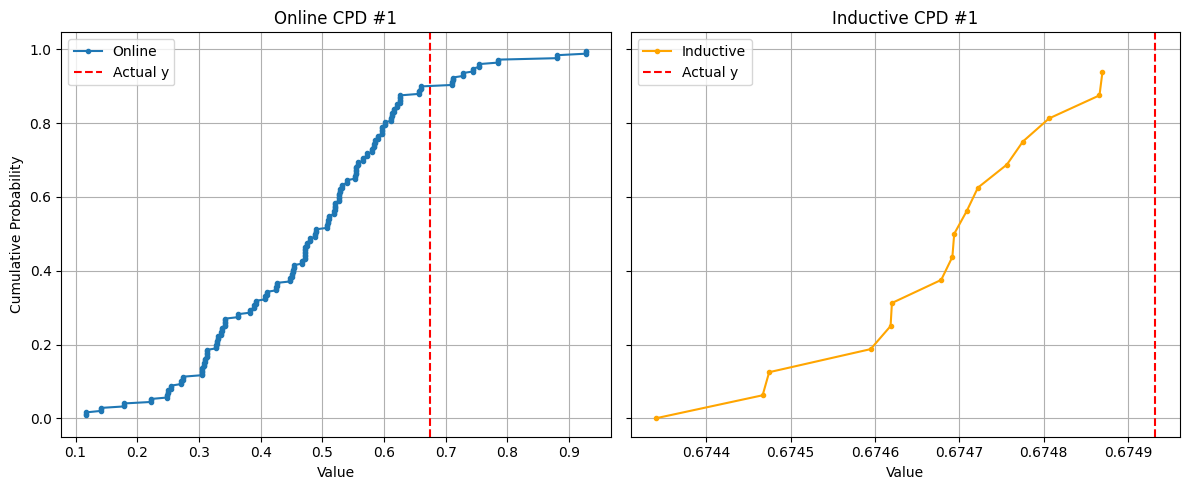

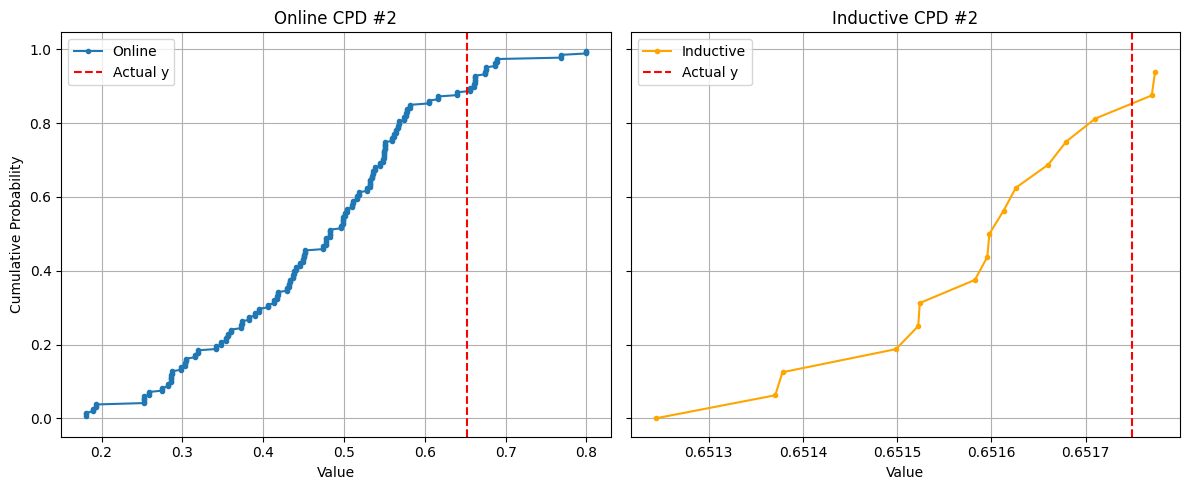

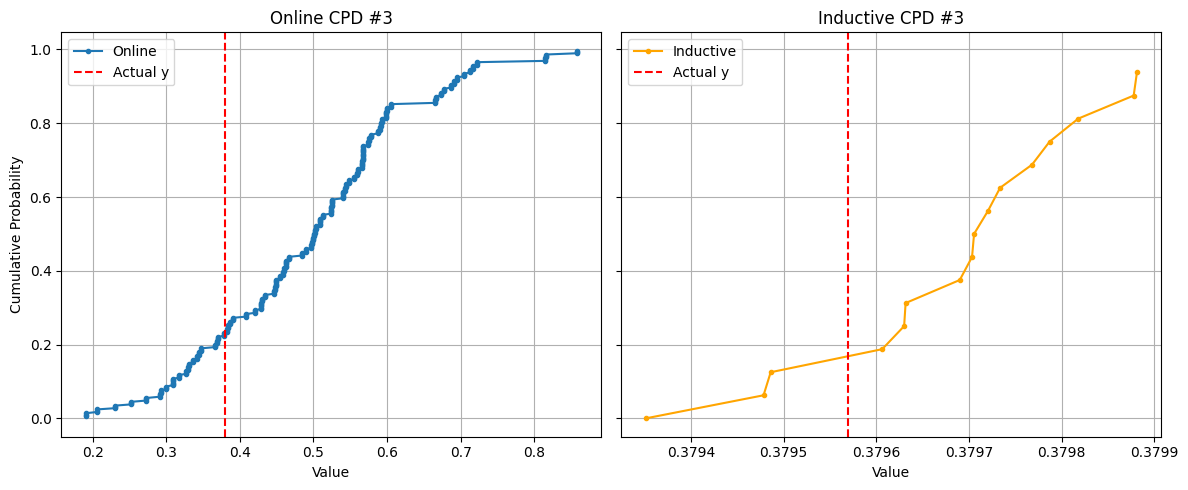

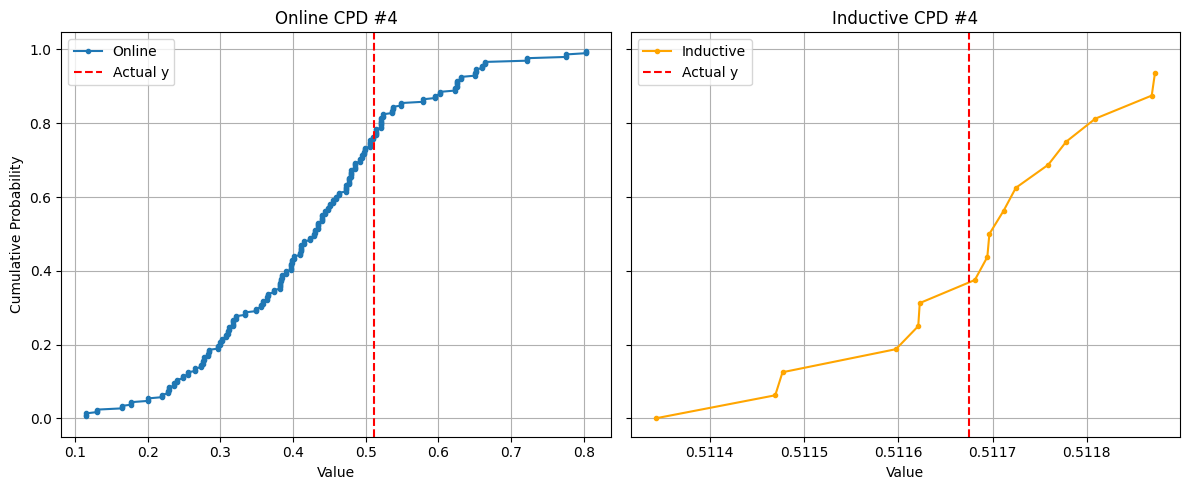

In [49]:
plot_wrong_examples(optimal_decisions, cpds_online, decisions_online, cpds_inductive, decisions_inductive)

In [47]:
incorrect_mask_inductive = [decision != optimal_decision for decision, optimal_decision in zip(decisions_inductive, optimal_decisions)]
incorrect_mask_online = [decision != optimal_decision for decision, optimal_decision in zip(decisions_online, optimal_decisions)]

print(f"# of mistakes inductive: {sum(incorrect_mask_inductive)}")
print(f"# of mistakes online: {sum(incorrect_mask_online)}")

# of mistakes inductive: 0
# of mistakes online: 4
